# Chapter 8. Semantic Search and Retrieval-Augmented Generation

Source:

**Chapter 8. Semantic Search and Retrieval-Augmented Generation** in Allamar and Grotendorst, “Hands-On Large Language Models”, O’Reilly Media Inc., September 2024.

https://learning.oreilly.com/library/view/hands-on-large-language/9781098150952/ch08.html#overview_of_semantic_search_and_retriev


### Loading your Cohere API key

In [2]:
!pip install cohere faiss-cpu rank_bm25 langchain langchain_community llama-cpp-python sentence-transformers

  Using cached cohere-5.13.12-py3-none-any.whl.metadata (3.4 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 22.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.9/252.9 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 90.3 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.7-cp310-cp310-linux_x86_64.whl size=4552780 sha256=593b370bfb50e3f15e02f57fa017027c1bf5f5958fd61d43d85f07c9320f033e
  Stored in directory: /root/.cache/pip/wheels/5c/8f/58/a39eb13258f3bbf64bb36ed76d31979579a6f175be38de06b7
Successfully built llama-cpp-python


In [4]:
import cohere
import numpy as np
import pandas as pd
from tqdm import tqdm

# Paste your API key here. Remember to not share publicly
COHERE_TOKEN = open("/cohere_mjack.apikey", "r").read().strip()

# Create and retrieve a Cohere API key from os.cohere.ai
co = cohere.Client(COHERE_TOKEN)

### Getting the text archive and chunking it

In [5]:
text = """
Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan.
It stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine.
Set in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind.

Brothers Christopher and Jonathan Nolan wrote the screenplay, which had its origins in a script Jonathan developed in 2007.
Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar.
Cinematographer Hoyte van Hoytema shot it on 35 mm movie film in the Panavision anamorphic format and IMAX 70 mm.
Principal photography began in late 2013 and took place in Alberta, Iceland, and Los Angeles.
Interstellar uses extensive practical and miniature effects and the company Double Negative created additional digital effects.

Interstellar premiered on October 26, 2014, in Los Angeles.
In the United States, it was first released on film stock, expanding to venues using digital projectors.
The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014.
It received acclaim for its performances, direction, screenplay, musical score, visual effects, ambition, themes, and emotional weight.
It has also received praise from many astronomers for its scientific accuracy and portrayal of theoretical astrophysics. Since its premiere, Interstellar gained a cult following,[5] and now is regarded by many sci-fi experts as one of the best science-fiction films of all time.
Interstellar was nominated for five awards at the 87th Academy Awards, winning Best Visual Effects, and received numerous other accolades"""

# Split into a list of sentences
texts = text.split('.')

# Clean up to remove empty spaces and new lines
texts = [t.strip(' \n') for t in texts]

### Embedding the text chunks

In [6]:
# Get the embeddings
response = co.embed(
  texts=texts,
  input_type="search_document",
).embeddings

embeds = np.array(response)
print(embeds.shape)

(15, 4096)


### Building the search index

**pip install faiss-cpu**

Source:
https://myscale.com/blog/installing-faiss-cpu-pip-step-by-step-guide/

In [7]:
import faiss

dim = embeds.shape[1]
index = faiss.IndexFlatL2(dim)
print(index.is_trained)

index.add(np.float32(embeds))

True


### Search the index

- Embed the query
- Present its embedding to the index
- Retrieve the most similar sentence from the Wikipedia article

In [8]:
def search(query, number_of_results=3):

  # 1. Get the query's embedding
  query_embed = co.embed(texts=[query], input_type="search_query",).embeddings[0]

  # 2. Retrieve the nearest neighbors
  distances, similar_item_ids = index.search(np.float32([query_embed]), number_of_results)

  # 3. Format the results
  texts_np = np.array(texts) # Convert texts list to numpy for easier indexing
  results = pd.DataFrame(
      data={
        'texts': texts_np[similar_item_ids[0]],
        'distance': distances[0],
      }
      )

  # 4. Print and return the results
  print(f"Query:'{query}'\nNearest neighbors:")
  return results

In [9]:
query = "how precise was the science"
results = search(query)
results

Query:'how precise was the science'
Nearest neighbors:


,texts,distance
0,It has also received praise from many astronom...,10757.371094
1,Caltech theoretical physicist and 2017 Nobel l...,11566.135742
2,Interstellar uses extensive practical and mini...,11922.841797


### Compare with results of a keyword search function

**pip install rank_bm25**

Source: BM25 algorithm

https://github.com/cohere-ai/cohere-developer-experience/tree/main/notebooks/guides

In [10]:
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction import _stop_words
import string

def bm25_tokenizer(text):
    tokenized_doc = []
    for token in text.lower().split():
        token = token.strip(string.punctuation)

        if len(token) > 0 and token not in _stop_words.ENGLISH_STOP_WORDS:
            tokenized_doc.append(token)
    return tokenized_doc


tokenized_corpus = []
for passage in tqdm(texts):
    tokenized_corpus.append(bm25_tokenizer(passage))

bm25 = BM25Okapi(tokenized_corpus)

def keyword_search(query, top_k=3, num_candidates=15):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -num_candidates)[-num_candidates:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)

    print(f"Top-3 lexical search (BM25) hits")
    for hit in bm25_hits[0:top_k]:
        print("\t{:.3f}\t{}".format(hit['score'], texts[hit['corpus_id']].replace("\n", " ")))

100%|██████████| 15/15 [00:00<00:00, 41971.02it/s]


In [11]:
keyword_search(query = "how precise was the science")

Input question: how precise was the science
Top-3 lexical search (BM25) hits
	1.789	Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan
	1.373	Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar
	0.000	It stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine


### Caveats of dense retrieval

In [12]:
query = "What is the mass of the moon?"
results = search(query)
results

Query:'What is the mass of the moon?'
Nearest neighbors:


,texts,distance
0,Cinematographer Hoyte van Hoytema shot it on 3...,12854.444336
1,The film had a worldwide gross over $677 milli...,13301.007812
2,It has also received praise from many astronom...,13332.000000


Problems:

- Depending on the query sometimes non of the returned results appear relevent. Possible fix: Set a threshold level.
- Dense retrieval will not work well for an exact match for a specific phrase.
- Questions whose answers span multiple sentences. Important technique: Chunking of long texts.

### Chunking long texts

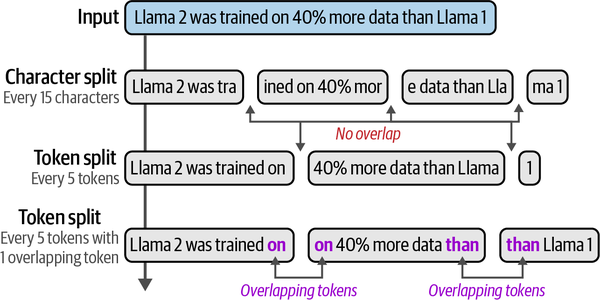

In [15]:
from IPython.display import Image
Image("holl_0808.png", width=700, height=500)

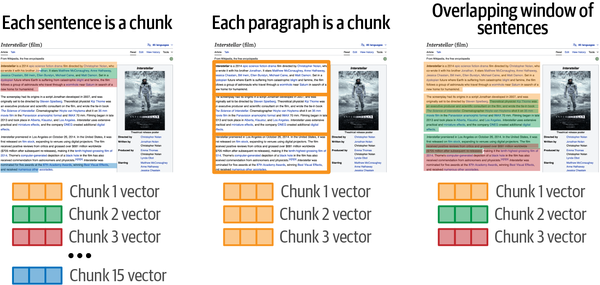

In [16]:
from IPython.display import Image
Image("holl_0809.png", width=700, height=500)

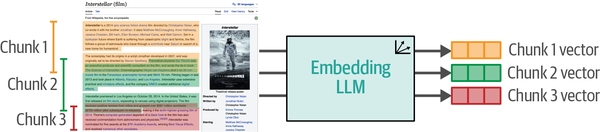

In [17]:
from IPython.display import Image
Image("holl_0810.png", width=700, height=500)

### Nearest neighbor search versus vector databases

- As you scale beyond to the millions of vectors, an optimized approach for retrieval is to rely on **approximate nearest neighbor search libraries** like **Annoy** or **FAISS.**

- Alternative: Vector databases like **Weaviate** or **Pinecone:**
    - A vector database allows you to add or delete vectors without having to rebuild the index.
    - They provide ways to filter your search or customize beyond vector distances.

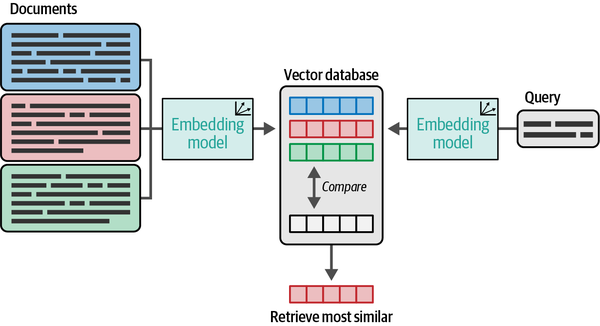

In [18]:
from IPython.display import Image
Image("holl_0811.png", width=700, height=500)

### Fine-tuning embedding models for dense retrieval

Goal:

Make the embedding of relevant queries closer to the document and at the same time make irrelevant queries farther from the document:

- Optimize text embeddings and not simply token embeddings.
- Get training data composed of queries and relevant results.
- Include negative examples of queries that are not relevant to the sentence during finetuning.

### Reranking

Changing the order of the search results based on relevance to the search query.

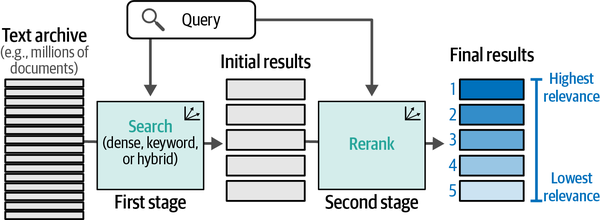

In [19]:
from IPython.display import Image
Image("holl_0814.png", width=700, height=500)

In [22]:
query = "how precise was the science"
results = co.rerank(query=query, documents=texts, top_n=3, return_documents=True)
results.results

[RerankResponseResultsItem(document=RerankResponseResultsItemDocument(text='It has also received praise from many astronomers for its scientific accuracy and portrayal of theoretical astrophysics'), index=12, relevance_score=0.16981852),
 RerankResponseResultsItem(document=RerankResponseResultsItemDocument(text='The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014'), index=10, relevance_score=0.07004896),
 RerankResponseResultsItem(document=RerankResponseResultsItemDocument(text='Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar'), index=4, relevance_score=0.0043994132)]

In [23]:
for idx, result in enumerate(results.results):
  print(idx, result.relevance_score , result.document.text)

0 0.16981852 It has also received praise from many astronomers for its scientific accuracy and portrayal of theoretical astrophysics
1 0.07004896 The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014
2 0.0043994132 Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar


#### First-stage retriever to use keyword search and dense retrieval:

Example:

Multilingual benchmark like MIRACL, a reranker can boost performance from 36.5 to 62.8, measured as nDCG@10.

In [24]:
# first-stage retriever to use keyword search and dense retrieval:

def keyword_and_reranking_search(query, top_k=3, num_candidates=10):
    print("Input question:", query)

    ##### BM25 search (lexical search) #####
    bm25_scores = bm25.get_scores(bm25_tokenizer(query))
    top_n = np.argpartition(bm25_scores, -num_candidates)[-num_candidates:]
    bm25_hits = [{'corpus_id': idx, 'score': bm25_scores[idx]} for idx in top_n]
    bm25_hits = sorted(bm25_hits, key=lambda x: x['score'], reverse=True)

    print(f"Top-3 lexical search (BM25) hits")
    for hit in bm25_hits[0:top_k]:
        print("\t{:.3f}\t{}".format(hit['score'], texts[hit['corpus_id']].replace("\n", " ")))


    #Add re-ranking
    docs = [texts[hit['corpus_id']] for hit in bm25_hits]

    print(f"\nTop-3 hits by rank-API ({len(bm25_hits)} BM25 hits re-ranked)")
    results = co.rerank(query=query, documents=docs, top_n=top_k, return_documents=True)
    # print(results.results)
    for hit in results.results:
        # print(hit)
        print("\t{:.3f}\t{}".format(hit.relevance_score, hit.document.text.replace("\n", " ")))


In [25]:
keyword_and_reranking_search(query = "how precise was the science")

Input question: how precise was the science
Top-3 lexical search (BM25) hits
	1.789	Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan
	1.373	Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar
	0.000	Interstellar uses extensive practical and miniature effects and the company Double Negative created additional digital effects

Top-3 hits by rank-API (10 BM25 hits re-ranked)
	0.004	Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar
	0.004	Set in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind
	0.003	Brothers Christopher and Jonat

### RAG - Retrieval Augmented Generation

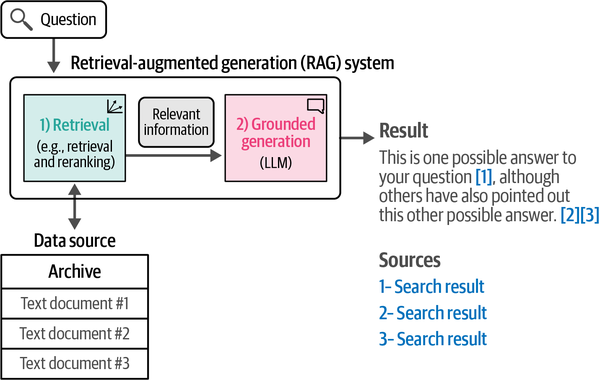

In [27]:
from IPython.display import Image
Image("holl_0825.png", width=700, height=500)

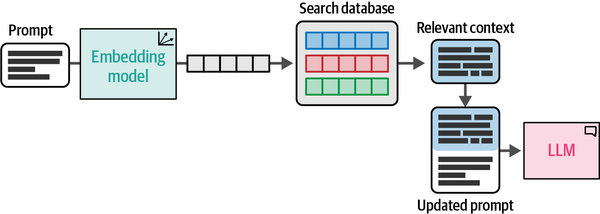

In [28]:
from IPython.display import Image
Image("holl_0826.png", width=700, height=500)

### Example: Grounded Generation with an LLM API

We’ll use embedding search to retrieve the top documents, then we’ll pass those to the co.chat endpoint along with the questions to provide a grounded answer:

In [29]:
query = "income generated"

# 1- Retrieval
# We'll use embedding search. But ideally we'd do hybrid
results = search(query)

# 2- Grounded Generation
docs_dict = [{'text': text} for text in results['texts']]
response = co.chat(
    message = query,
    documents=docs_dict
)

print(response.text)

Query:'income generated'
Nearest neighbors:
The film grossed over $677 million worldwide and $773 million with subsequent re-releases.


### Example: RAG with Local Models

**pip install langchain**

**pip install llama-cpp-python**

**pip install sentence-transformers**

In [31]:
from huggingface_hub import login
HF_TOKEN = open("/hugginface_mjack.apikey", "r").read().strip()
login(HF_TOKEN)

In [32]:
!huggingface-cli download microsoft/Phi-3-mini-4k-instruct-gguf Phi-3-mini-4k-instruct-q4.gguf --local-dir . --local-dir-use-symlinks False

/usr/local/lib/python3.10/dist-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Phi-3-mini-4k-instruct-q4.gguf: 100% 2.39G/2.39G [00:59<00:00, 40.1MB/s]
Download complete. Moving file to Phi-3-mini-4k-instruct-q4.gguf
Phi-3-mini-4k-instruct-q4.gguf


In [33]:
from langchain_community.llms import LlamaCpp

llm = LlamaCpp(
    model_path="Phi-3-mini-4k-instruct-q4.gguf",
    n_gpu_layers=-1,
    max_tokens=500,
    n_ctx=2048,
    seed=42,
    verbose=False
)

llama_init_from_model: n_batch is less than GGML_KQ_MASK_PAD - increasing to 32
llama_init_from_model: n_ctx_per_seq (2048) < n_ctx_train (4096) -- the full capacity of the model will not be utilized


In [34]:
# embedding model:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings

# Embedding model for converting text to numerical representations
embedding_model = HuggingFaceEmbeddings(
    model_name='thenlper/gte-small'
)

<ipython-input-34-c285ffea59ea>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [35]:
# vector database:
from langchain.vectorstores import FAISS

# Create a local vector database
db = FAISS.from_texts(texts, embedding_model)

In [36]:
from langchain import PromptTemplate

# Create a prompt template
template = """<|user|>
Relevant information:
{context}

Provide a concise answer the following question using the relevant information provided above:
{question}<|end|>
<|assistant|>"""

prompt = PromptTemplate(
    template=template,
    input_variables=["context", "question"]
)

In [37]:
from langchain.chains import RetrievalQA

# RAG pipeline
rag = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type='stuff',
    retriever=db.as_retriever(),
    chain_type_kwargs={
        "prompt": prompt
    },
    verbose=True
)

In [38]:
# call model:
rag.invoke('Income generated')



> Entering new RetrievalQA chain...

> Finished chain.


{'query': 'Income generated',
 'result': ' Interstellar generated over $677 million worldwide, with a total of approximately $773 million after subsequent re-releases. It was initially released on film stock and later expanded to digital projectors in the United States, contributing to its box office success.'}

### Advanced RAG Techniques

- Query rewriting
- Multi-query RAG
- Multi-hop RAG
- Query routing
- Agentic RAG


### RAG Evaluation

#### Human evaluations:

**Fluency:**
Whether the generated text is fluent and cohesive.

**Perceived utility:**
Whether the generated answer is helpful and informative.

**Citation recall:**
The proportion of generated statements about the external world that are fully supported by their citations.

**Citation precision:**
The proportion of generated citations that support their associated statements.


#### Automate with **LLM judges**:

**Faithfulness:**
Whether the answer is consistent with the provided context.

**Answer relevance:**
How relevant the answer is to the question.